<a href="https://colab.research.google.com/github/mamadoz79/Neural_networks_CA3/blob/main/CA3_part1_NN_Temperature_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
import os
import itertools
from sklearn.model_selection import train_test_split
from scipy import *
from scipy.linalg import norm, pinv
from scipy.optimize import minimize
from sklearn.cluster import MiniBatchKMeans as kmeans
from matplotlib import pyplot as plt
from numpy import random
import timeit

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


data

In [3]:
def normalize(df_min_max_scaled):
    for column in df_min_max_scaled.columns:
        df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())
    return df_min_max_scaled

In [68]:
data_sets = {}
for i in os.listdir('/content/drive/MyDrive/Time-series/'):
    name = i.split('.')[0]
    data_sets.update({name : pd.read_excel(f"/content/drive/MyDrive/Time-series/{i}", header=None)})
    data_sets[name] = {"target": np.array(normalize(data_sets[name].iloc[:,-1:])), "data": np.array(normalize(data_sets[name].iloc[:,:-1]))}

<ipython-input-3-d8db9858f8fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())
<ipython-input-3-d8db9858f8fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())


In [69]:
X_train, X_test, y_train, y_test = train_test_split(data_sets['Temperature Dataset']['data'], data_sets['Temperature Dataset']['target'], test_size=0.3)

GMDH

In [70]:
class GMDH:
    def __init__(self):
        self.weights = np.array([random.random() for i in range(6)])
        self.etha = 0.01
        self.outputs = []
        self.test_output = []
        self.error_test = []
        self.error_train = []
        self.local_error_test = []
        self.local_error_train = []

    def feed_forward(self, X, target, test_flag):
        self.x1, self.x2 = X
        self.target = target
        self.output = self.dot_product()
        self.error = self.calc_error()
        if not test_flag:
            self.outputs.append(self.output)
            self.local_error_train.append(self.error)
        else:
            self.test_output.append(self.output)
            self.local_error_test.append(self.error)

    def make_error_list(self, arg):
        if arg == 'test':
            self.error_test.append(self.local_error_test)
            self.local_error_test = []
        elif arg == 'train':
            self.error_train.append(self.local_error_train)
            self.local_error_train = []

    def back_propag(self):
        self.weights -= (np.array([1, self.x1, self.x2, self.x1**2, self.x1*self.x2, self.x2**2]) * self.error * -1 * self.etha)

    def dot_product(self):
        return self.weights[0] + self.weights[1]*self.x1 + self.weights[2]*self.x2 + self.weights[3]*(self.x1**2) + self.weights[4]*(self.x1*self.x2) + self.weights[5]*(self.x2**2)

    def calc_error(self):
        return self.target - self.output


In [71]:
GMDH_neurons = [GMDH() for i in range(3)]

In [72]:
def GMDH_training(Data, Target, Data_test, Target_test, epoch=200, GMDH_neurons=GMDH_neurons):
    for ep in range(epoch):
        for neuron in GMDH_neurons:
            neuron.outputs = []
        #train part
        for (data, target) in zip(Data, Target):
            [i.feed_forward(j, target[0], False) for (i, j) in zip(GMDH_neurons, list(itertools.combinations(data, 2)))]
            [i.back_propag() for i in GMDH_neurons]
        for ne in GMDH_neurons:
            ne.make_error_list('train')

        for neuron in GMDH_neurons:
            neuron.test_output = []

        for (data, target) in zip(Data_test, Target_test):
            [i.feed_forward(j, target[0], True) for (i, j) in zip(GMDH_neurons, list(itertools.combinations(data, 2)))]
        for ne in GMDH_neurons:
            ne.make_error_list('test')

    for neuron in GMDH_neurons:
        neuron.outputs = np.array(neuron.outputs)

In [73]:
GMDH_training(X_train, y_train, X_test, y_test)

In [74]:
rbf_x_train = np.array(list(zip(*[i.outputs for i in GMDH_neurons])))

In [75]:
rbf_x_test = np.array(list(zip(*[i.test_output for i in GMDH_neurons])))

RBF

In [76]:
def gaussian(x, mean, sigma):
    sumation = np.sum(np.power((x - mean), 2), 1)
    return np.exp(-0.5 * (1/np.power(np.transpose(sigma), 2)) * sumation)

def gaussian_deriviate_mean(x, mean, sigma, o1):
    sumation = x - mean
    return (1/np.power(sigma, 2)) * sumation * np.transpose(o1)

def gaussian_deriviate_sigma(x, mean, sigma, o1):
    sumation = np.sum(np.power((x - mean), 2), 1)
    sumation = np.reshape(sumation, (-1, 1))
    return (1/np.power(sigma, 3)) * sumation * np.transpose(o1)

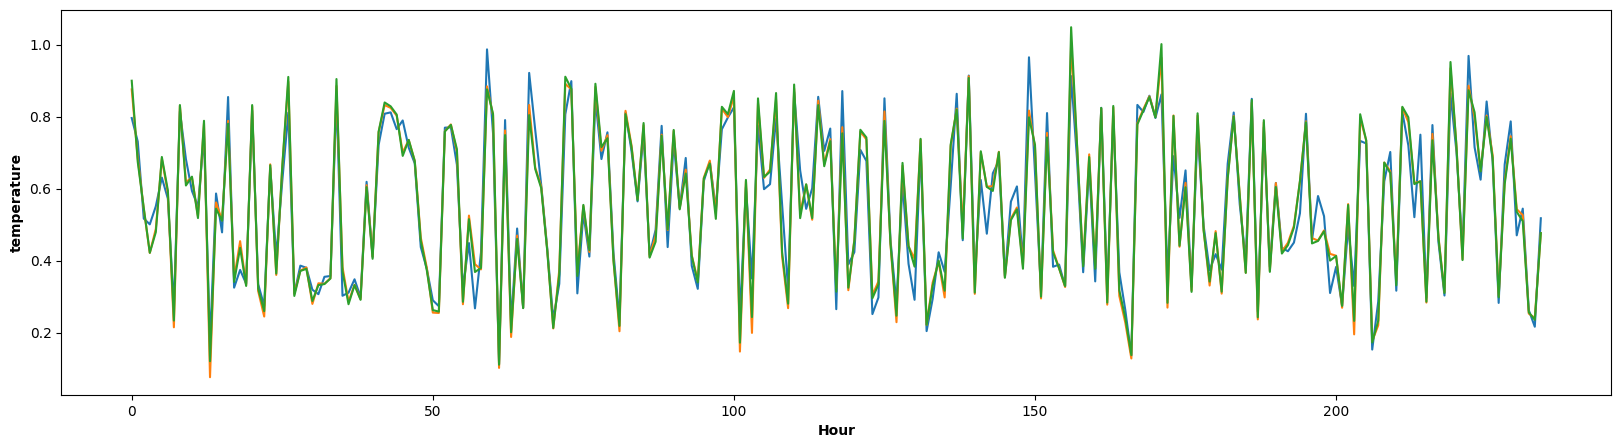

In [77]:
data_T = rbf_x_train[:]
data_P = rbf_x_train[:]
plt.figure(figsize=(20,5))
plt.plot(data_P)
plt.xlabel('Hour', fontweight ='bold')
plt.ylabel('temperature', fontweight ='bold')
plt.show()

In [78]:
l1_neurons = 3
l2_neurons = 1
lrw = 0.05
lrm = 0.05
lrs = 0.05
epochs = 200

MSE_train = []
MSE_test = []

In [79]:
input_dimension = np.shape(rbf_x_train)[1]

In [80]:
mean = np.random.uniform(low=-1, high=1, size=(l1_neurons, input_dimension))
sigma = np.random.uniform(low=-1, high=1, size=(l1_neurons, l2_neurons))
w = np.random.uniform(low=-1, high=1, size=(l1_neurons, l2_neurons))

In [81]:
def Train(w, mean, sigma):
    output_train = []
    sqr_err_epoch_train = []

    for i in range(np.shape(rbf_x_train)[0]):
        #x = np.reshape(rbf_x_train[i], (1,-1)) # x: (1, 4)
        x = rbf_x_train[i][:]
        # Feed-Forward
        # Layer 1
        o1 = gaussian(x, mean, sigma) # o1: (1, l1_neurons)
        # Layer 2
        o2 = np.matmul(o1, w) # o2: (1, 1)

        output_train.append(o2[0])

        # Error
        err = y_train[i] - o2[0]
        sqr_err_epoch_train.append(err**2)

        # Back propagation
        mean = np.subtract(mean, (lrm * err * -1 * w * gaussian_deriviate_mean(x, mean, sigma, o1)))
        #
        sigma = np.subtract(sigma, (lrs * err * -1 * w * gaussian_deriviate_sigma(x, mean, sigma, o1)))
        #
        w = np.subtract(w, (lrw * err * -1 * np.transpose(o1)))

    mse_epoch_train = 0.5 * ((sum(sqr_err_epoch_train))/np.shape(rbf_x_train)[0])
    MSE_train.append(mse_epoch_train[0])
    return output_train, w, mean, sigma

def Test(w, mean, sigma):
    sqr_err_epoch_test = []
    output_test = []

    for i in range(np.shape(rbf_x_test)[0]):
        x = np.reshape(rbf_x_test[i], (1,-1))
        # Feed-Forward
        # Layer 1
        o1 = gaussian(x, mean, sigma)
        # Layer 2
        o2 = np.matmul(o1, w)

        output_test.append(o2[0])

        # Error
        err = y_test[i] - o2[0]
        sqr_err_epoch_test.append(err ** 2)

    mse_epoch_test = 0.5 * ((sum(sqr_err_epoch_test))/np.shape(rbf_x_test)[0])
    MSE_test.append(mse_epoch_test[0])
    return output_test

In [82]:
def Plot_results(output_train,
                 output_test,
                 m_train,
                 b_train,
                 m_test,
                 b_test):
    # Plots
    fig = plt.figure()
    fig.set_size_inches(25, 15)

    axs = fig.add_subplot(3, 2, 1)
    axs.plot(MSE_train, 'b')
    axs.set_title('MSE Train')
    axs = fig.add_subplot(3, 2, 2)
    axs.plot(MSE_test, 'r')
    axs.set_title('Mse Test')
    #
    axs = fig.add_subplot(3, 2, 3)
    axs.plot(y_train, 'b')
    axs.plot(output_train, 'r')
    axs.set_title('Output Train')
    axs = fig.add_subplot(3, 2, 4)
    axs.plot(y_test, 'b')
    axs.plot(output_test, 'r')
    axs.set_title('Output Test')
    #
    axs = fig.add_subplot(3, 2, 5)
    axs.plot(y_train, output_train, 'b*')
    axs.plot(y_train, m_train*y_train+b_train,'r')
    axs.set_title('Regression Train')
    axs = fig.add_subplot(3, 2, 6)
    axs.plot(y_test, output_test, 'b*')
    axs.plot(y_test, m_test*y_test+b_test,'r')
    axs.set_title('Regression Test')
    plt.show()
    time.sleep(1)
    plt.close(fig)

==> Start Training ...


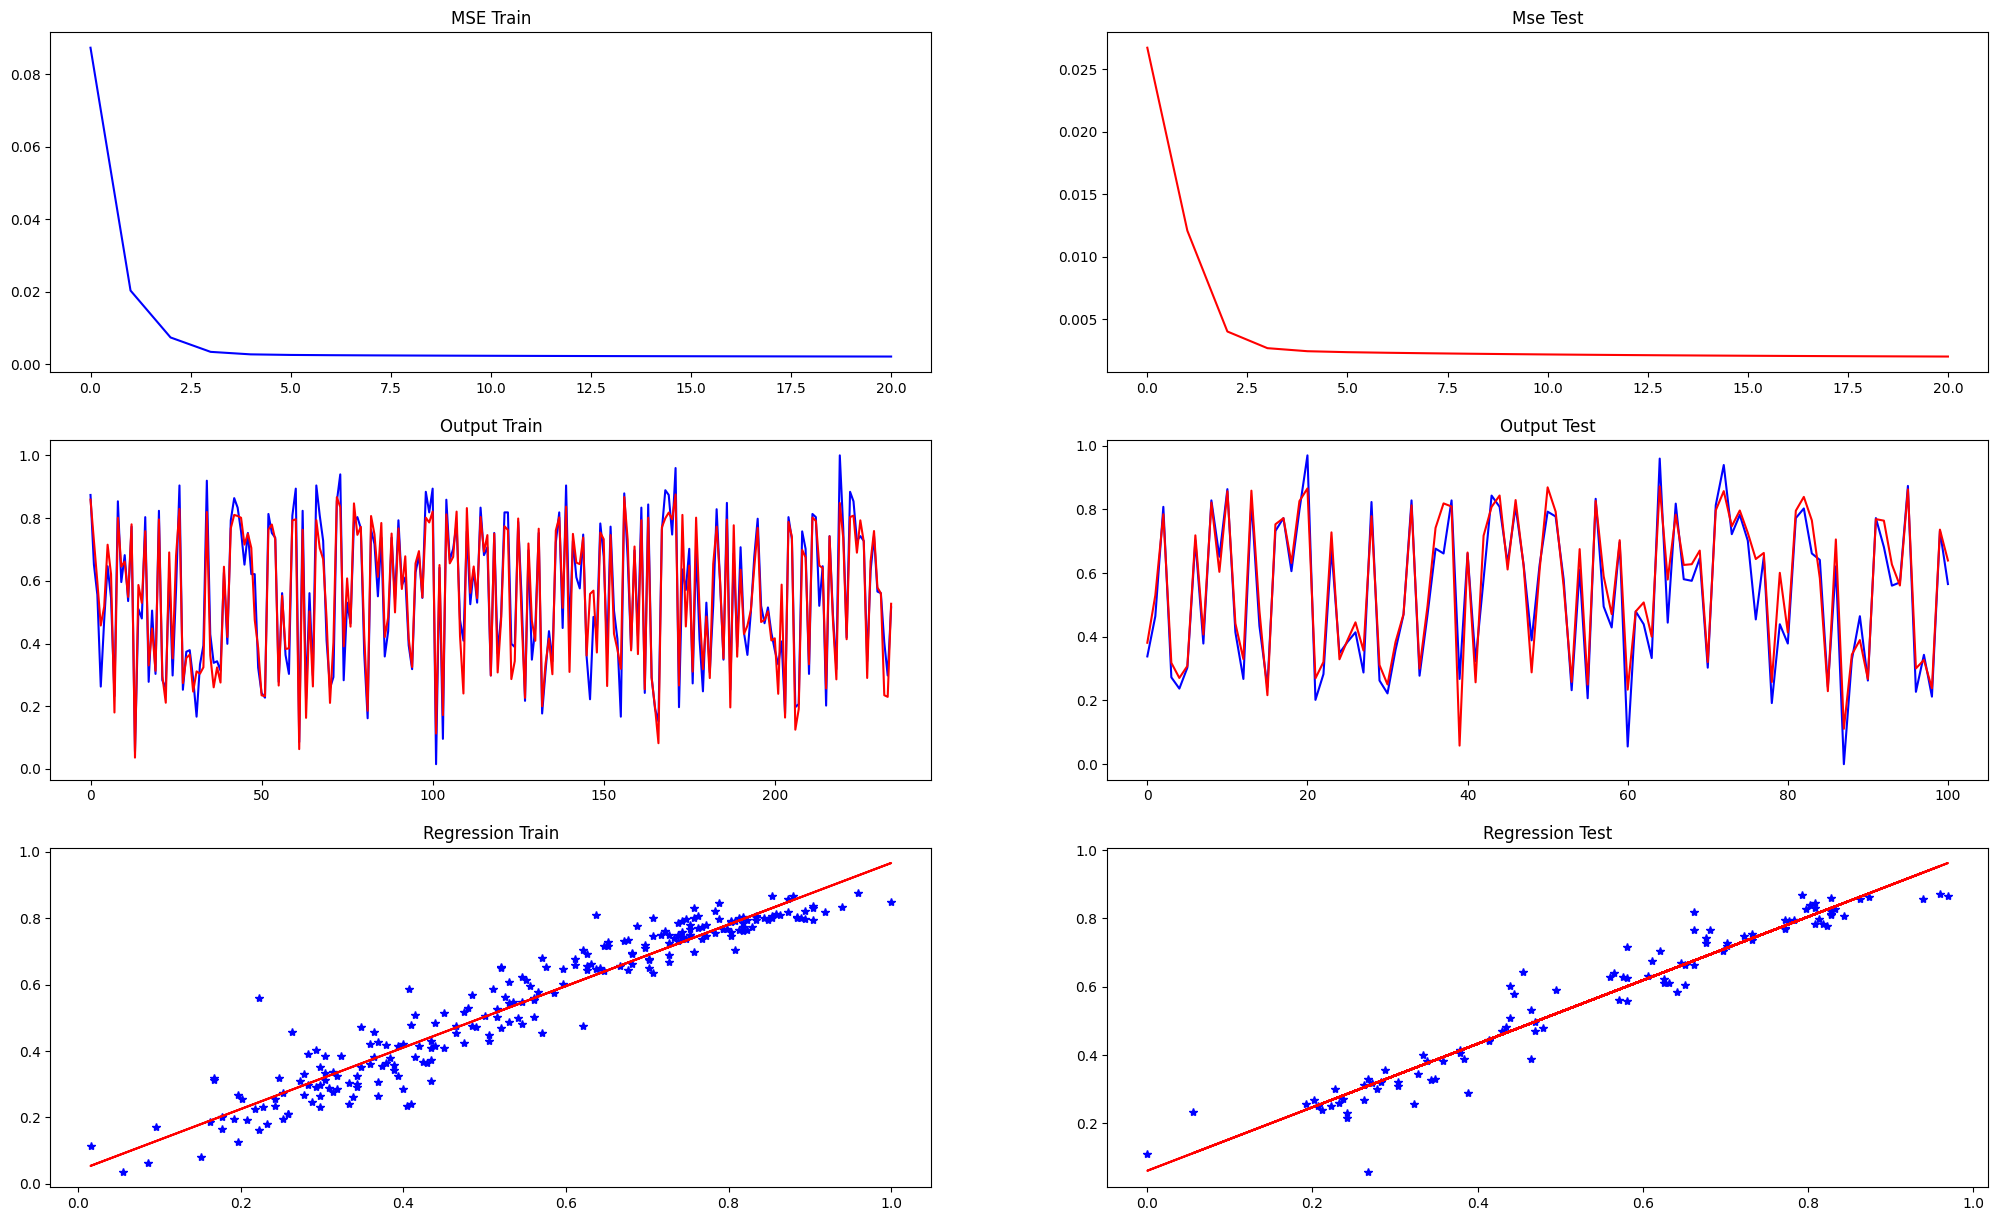

Epoch: 21 	, time: 2.332
MSE_train: 0.0021 	, MSE_test: 0.0020
[0.9258769] [0.03999622] [0.92853358] [0.06154874]
Epoch: 22 	, time: 0.023
MSE_train: 0.0021 	, MSE_test: 0.0020
[0.9258768] [0.04002311] [0.92869876] [0.06152115]
Epoch: 23 	, time: 0.021
MSE_train: 0.0021 	, MSE_test: 0.0020
[0.92588225] [0.04004578] [0.92886038] [0.06149436]
Epoch: 24 	, time: 0.023
MSE_train: 0.0021 	, MSE_test: 0.0020
[0.92589249] [0.04006472] [0.92901839] [0.0614684]
Epoch: 25 	, time: 0.026
MSE_train: 0.0021 	, MSE_test: 0.0020
[0.92590686] [0.04008035] [0.92917275] [0.06144327]
Epoch: 26 	, time: 0.026
MSE_train: 0.0021 	, MSE_test: 0.0020
[0.92592473] [0.04009305] [0.92932343] [0.06141899]
Epoch: 27 	, time: 0.025
MSE_train: 0.0020 	, MSE_test: 0.0020
[0.92594559] [0.04010317] [0.92947043] [0.06139556]
Epoch: 28 	, time: 0.023
MSE_train: 0.0020 	, MSE_test: 0.0020
[0.92596895] [0.04011101] [0.92961375] [0.06137301]
Epoch: 29 	, time: 0.023
MSE_train: 0.0020 	, MSE_test: 0.0020
[0.92599439] [0.0401

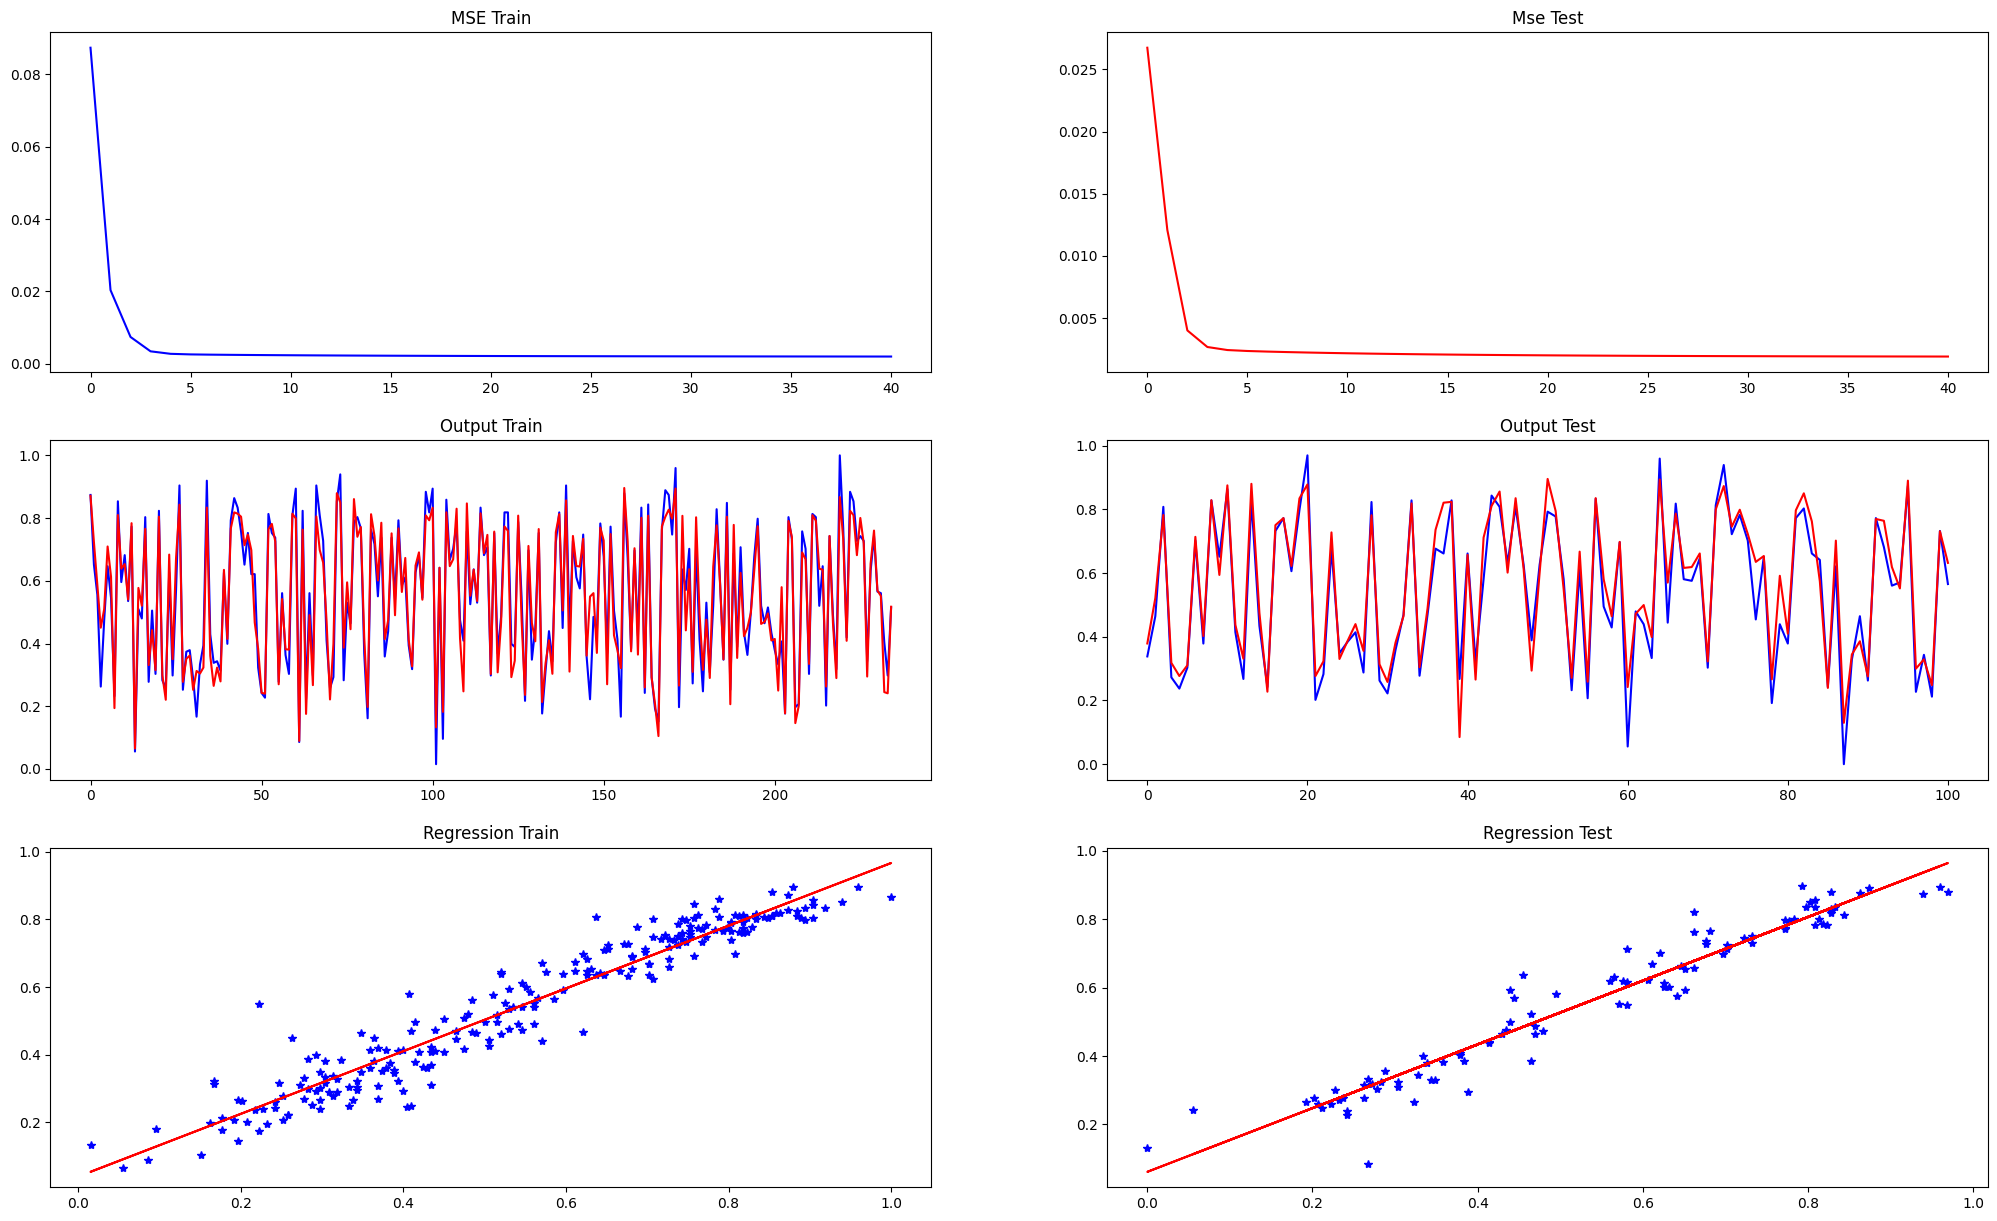

Epoch: 41 	, time: 2.658
MSE_train: 0.0020 	, MSE_test: 0.0019
[0.92636536] [0.04009917] [0.9311646] [0.06115559]
Epoch: 42 	, time: 0.036
MSE_train: 0.0020 	, MSE_test: 0.0019
[0.9263969] [0.04009397] [0.93126236] [0.06114408]
Epoch: 43 	, time: 0.039
MSE_train: 0.0020 	, MSE_test: 0.0019
[0.92642812] [0.04008854] [0.93135744] [0.06113319]
Epoch: 44 	, time: 0.035
MSE_train: 0.0020 	, MSE_test: 0.0019
[0.92645898] [0.04008292] [0.93144992] [0.0611229]
Epoch: 45 	, time: 0.037
MSE_train: 0.0020 	, MSE_test: 0.0019
[0.92648944] [0.04007715] [0.93153988] [0.06111319]
Epoch: 46 	, time: 0.042
MSE_train: 0.0019 	, MSE_test: 0.0019
[0.92651947] [0.04007127] [0.93162739] [0.06110403]
Epoch: 47 	, time: 0.044
MSE_train: 0.0019 	, MSE_test: 0.0019
[0.92654904] [0.04006531] [0.93171253] [0.06109539]
Epoch: 48 	, time: 0.036
MSE_train: 0.0019 	, MSE_test: 0.0019
[0.92657813] [0.04005928] [0.93179538] [0.06108725]
Epoch: 49 	, time: 0.037
MSE_train: 0.0019 	, MSE_test: 0.0019
[0.92660674] [0.0400

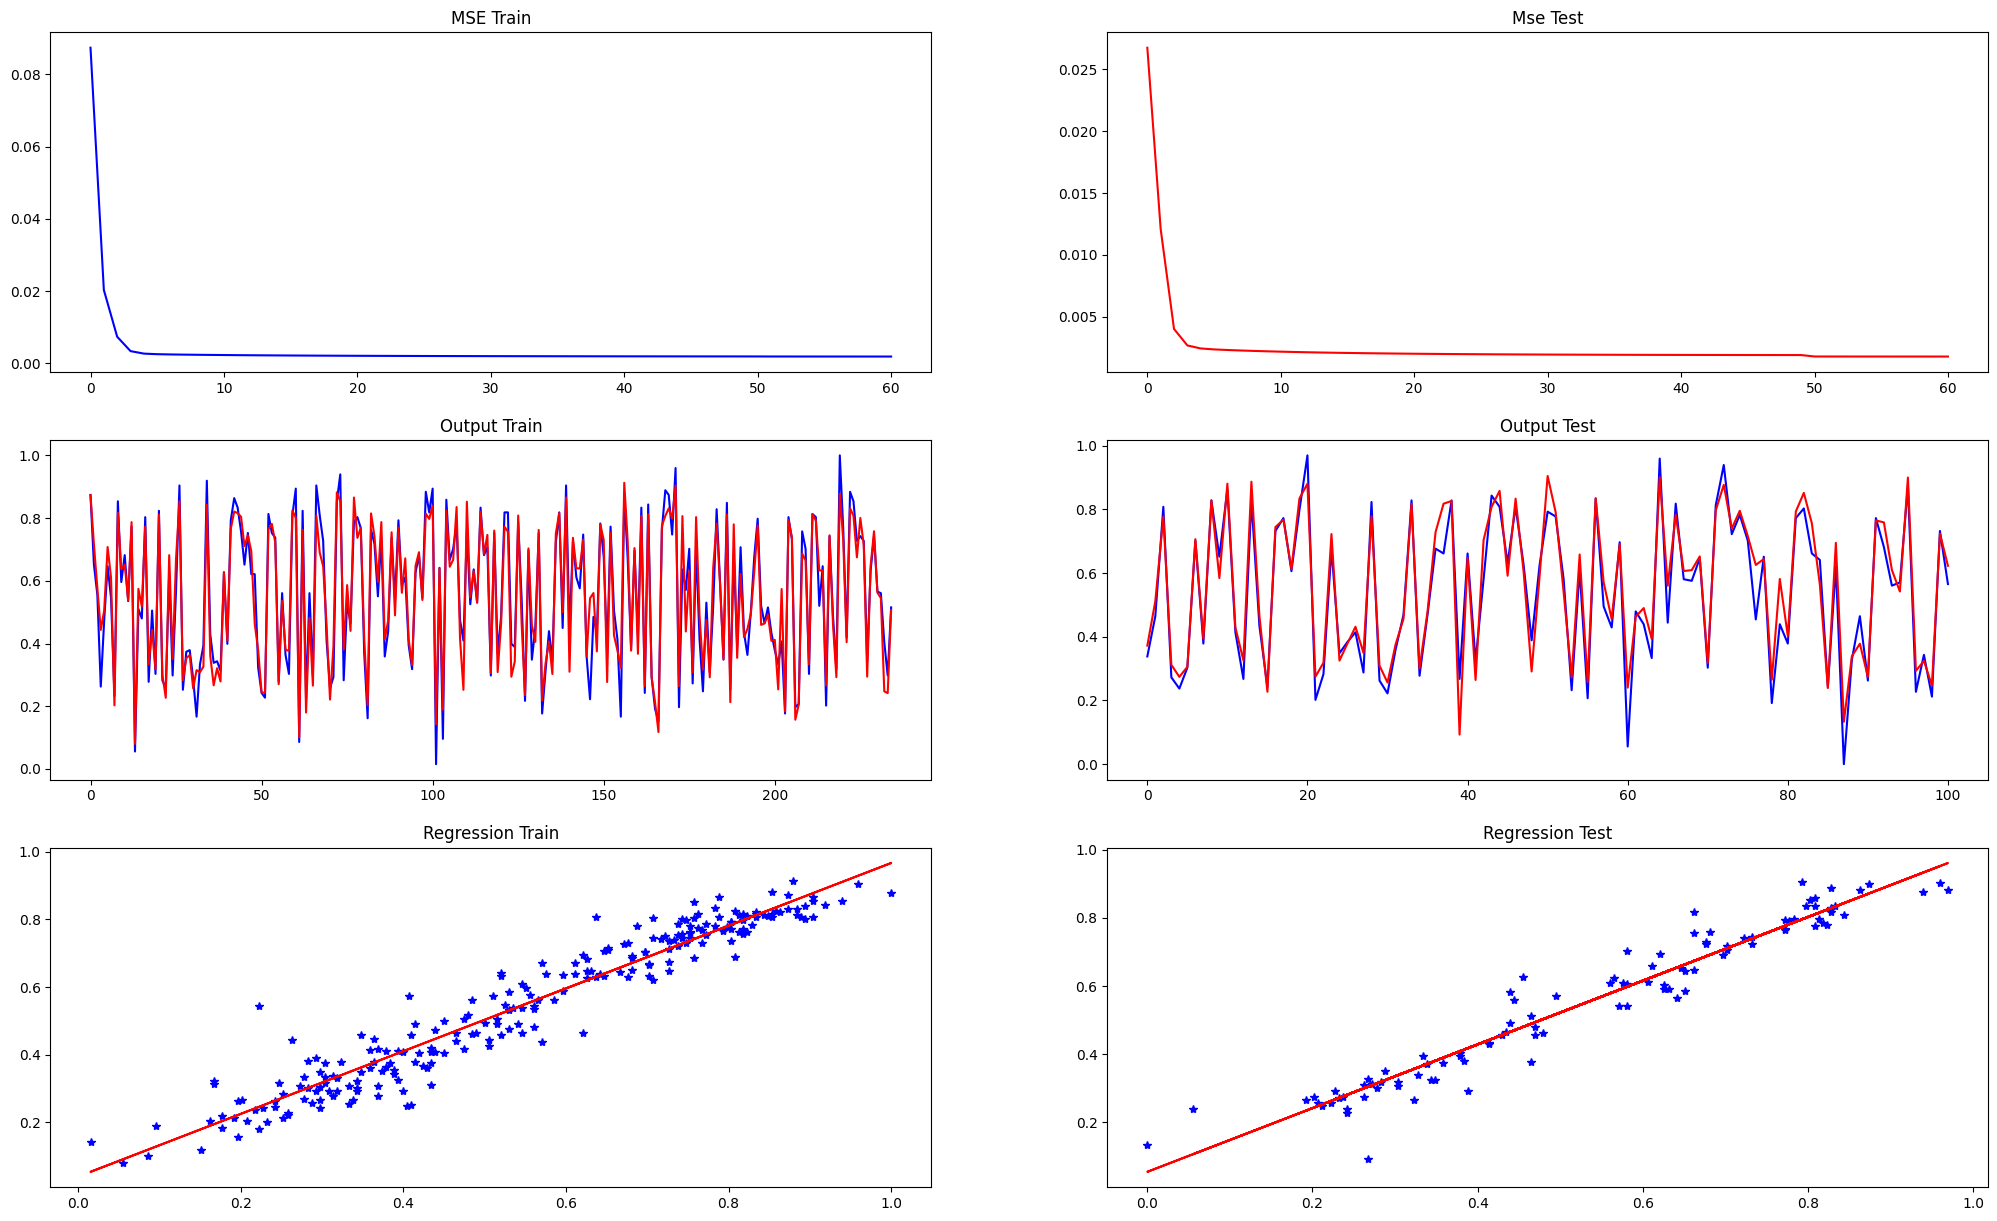

Epoch: 61 	, time: 2.105
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92679385] [0.04001993] [0.93471246] [0.05465467]
Epoch: 62 	, time: 0.025
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92681261] [0.04001514] [0.9347523] [0.05465611]
Epoch: 63 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92683063] [0.04001065] [0.9347911] [0.05465776]
Epoch: 64 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.9268481] [0.04000634] [0.93482902] [0.05465953]
Epoch: 65 	, time: 0.026
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92686515] [0.04000215] [0.93486616] [0.05466139]
Epoch: 66 	, time: 0.024
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92688185] [0.03999805] [0.93490258] [0.0546633]
Epoch: 67 	, time: 0.026
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92689824] [0.03999402] [0.93493832] [0.05466525]
Epoch: 68 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92691434] [0.03999004] [0.93497342] [0.05466721]
Epoch: 69 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92693016] [0.03998

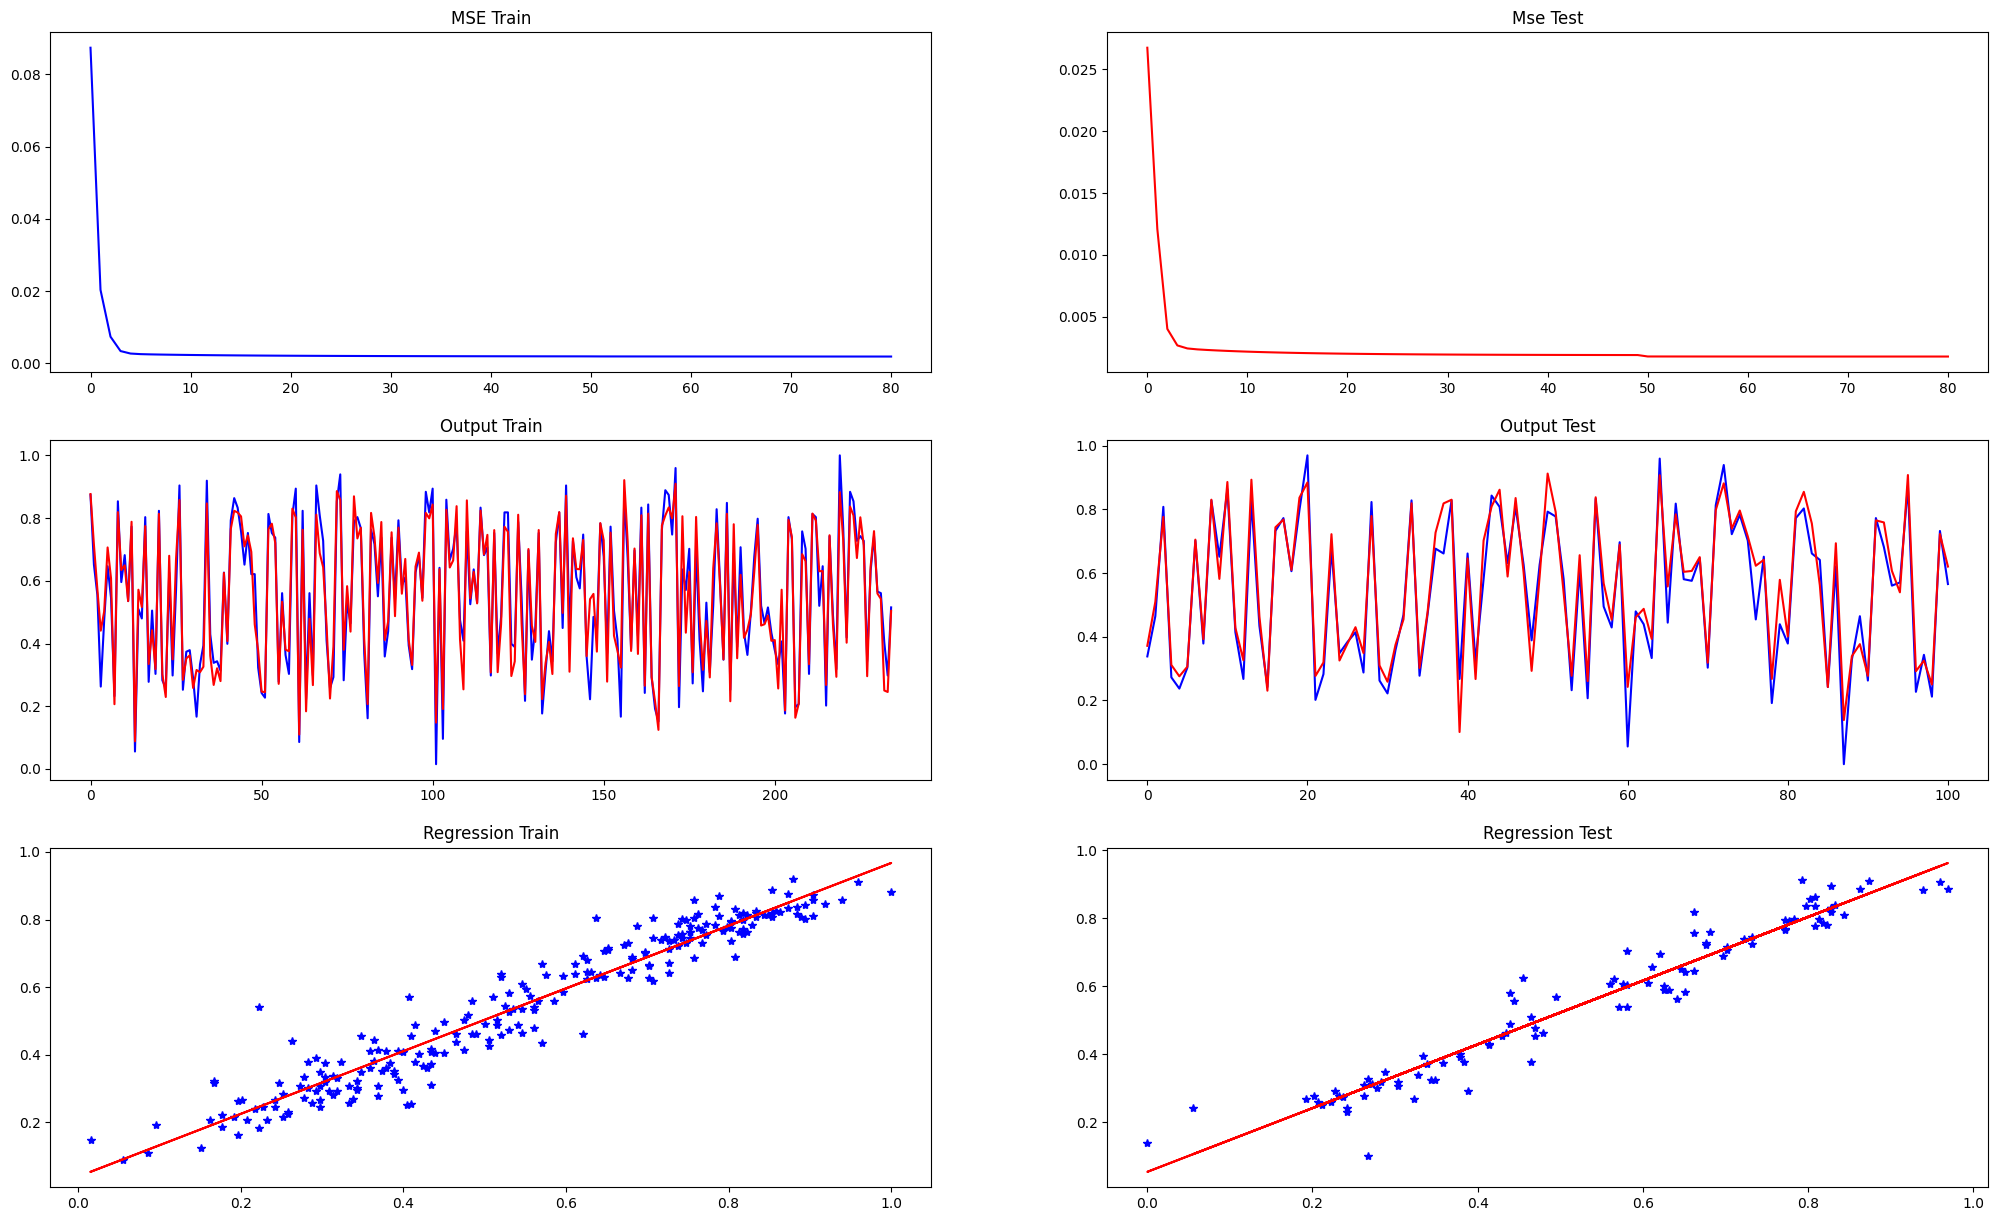

Epoch: 81 	, time: 2.104
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.9271011] [0.0399427] [0.93537779] [0.0546928]
Epoch: 82 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92711387] [0.03993938] [0.9354053] [0.05469468]
Epoch: 83 	, time: 0.025
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92712644] [0.03993611] [0.93543236] [0.05469654]
Epoch: 84 	, time: 0.029
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92713879] [0.03993289] [0.93545896] [0.05469837]
Epoch: 85 	, time: 0.032
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92715094] [0.03992971] [0.93548512] [0.05470017]
Epoch: 86 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92716289] [0.03992658] [0.93551084] [0.05470195]
Epoch: 87 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92717465] [0.0399235] [0.93553613] [0.05470369]
Epoch: 88 	, time: 0.022
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.9271862] [0.03992045] [0.93556101] [0.0547054]
Epoch: 89 	, time: 0.024
MSE_train: 0.0019 	, MSE_test: 0.0018
[0.92719757] [0.03991746

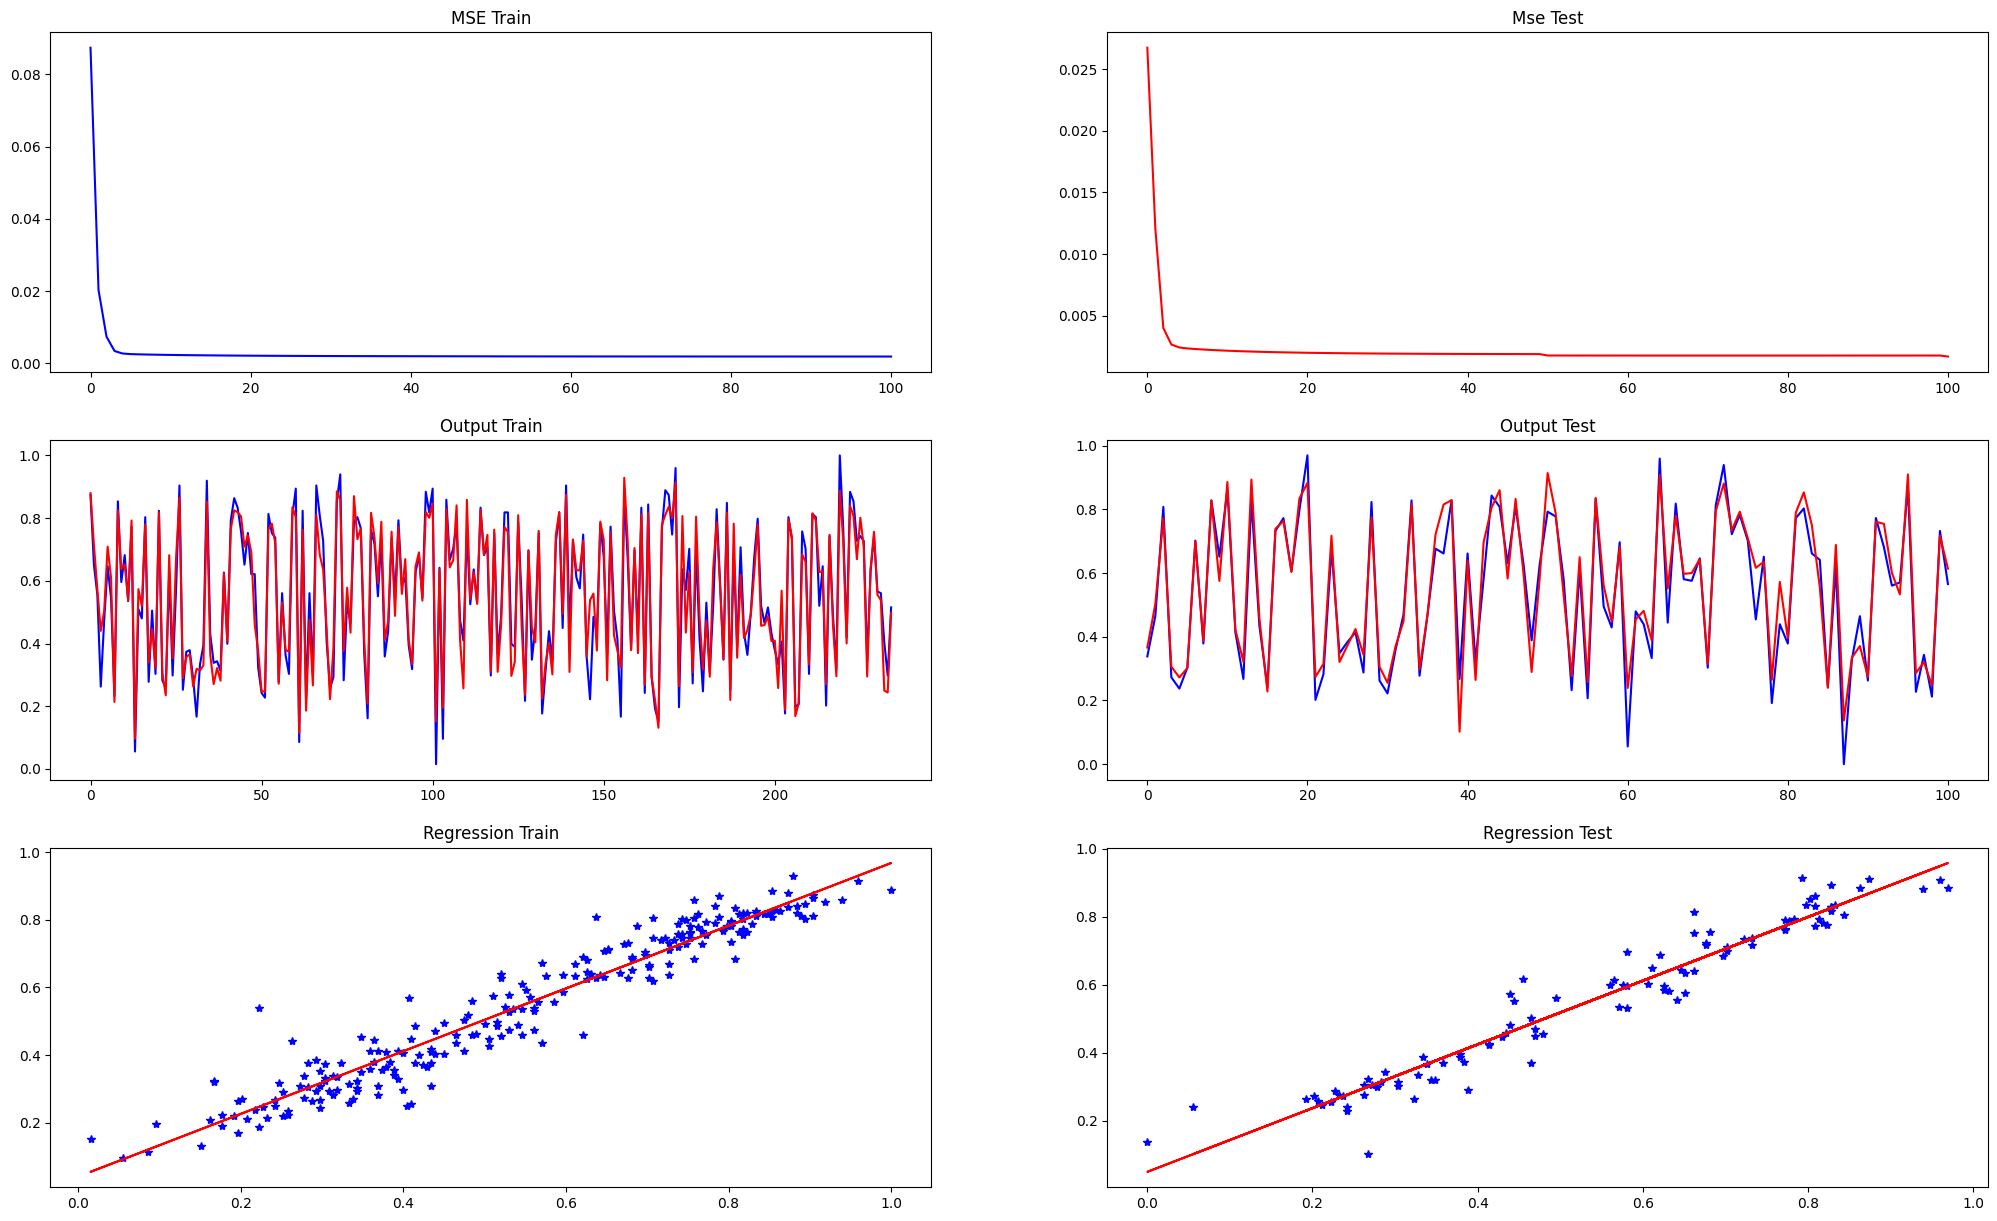

Epoch: 101 	, time: 2.273
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92639552] [0.0409118] [0.93707714] [0.04945546]
Epoch: 102 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92692959] [0.04009122] [0.93725009] [0.04937195]
Epoch: 103 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92706874] [0.04001795] [0.93736837] [0.049318]
Epoch: 104 	, time: 0.024
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92716265] [0.03996914] [0.93745068] [0.04928301]
Epoch: 105 	, time: 0.025
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92722679] [0.03993638] [0.93750927] [0.04926051]
Epoch: 106 	, time: 0.027
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92727128] [0.03991419] [0.93755219] [0.0492462]
Epoch: 107 	, time: 0.025
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92730281] [0.03989897] [0.93758474] [0.04923729]
Epoch: 108 	, time: 0.027
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.9273258] [0.03988834] [0.93761043] [0.04923191]
Epoch: 109 	, time: 0.030
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92734312] 

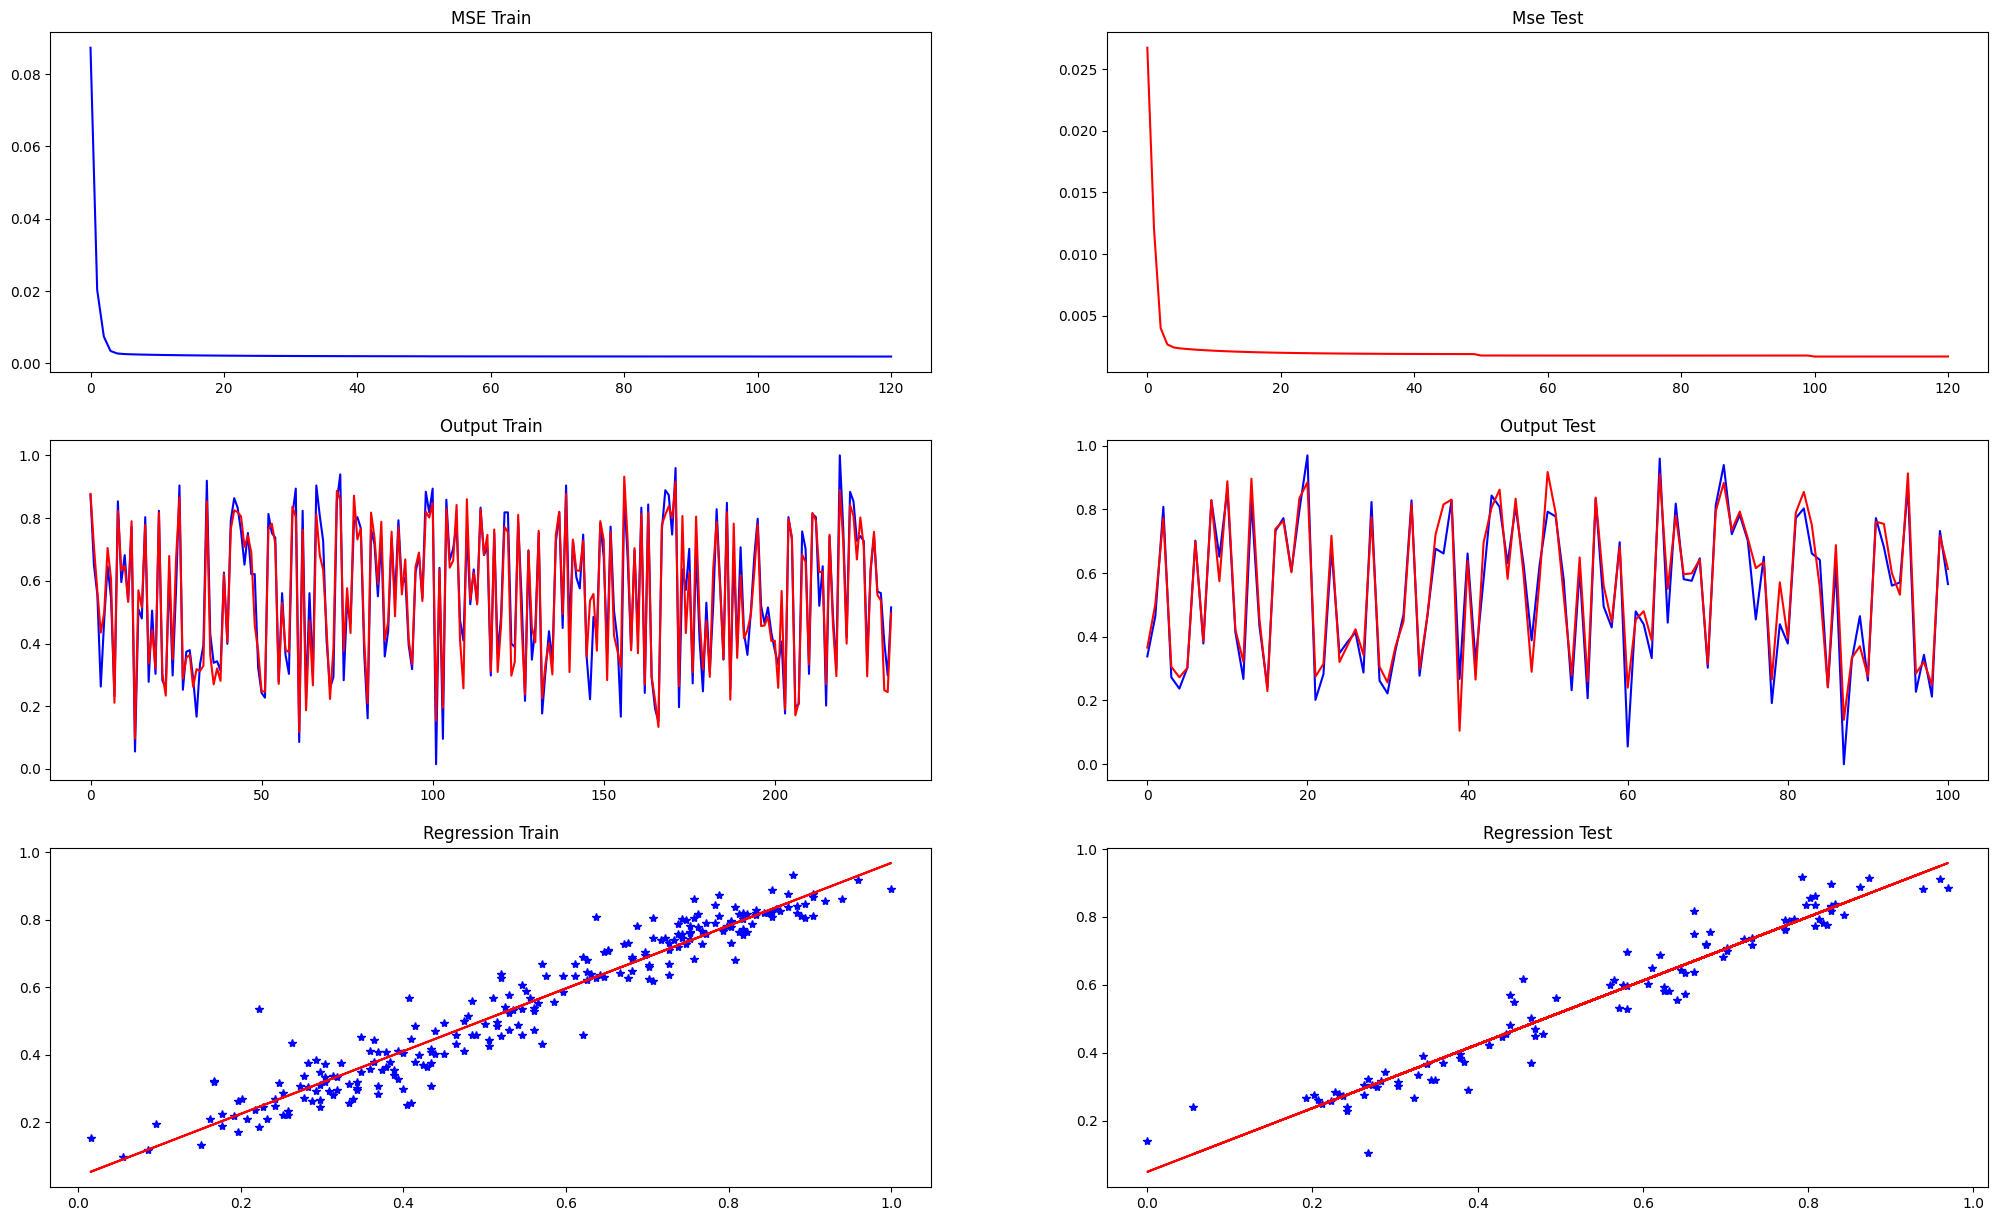

Epoch: 121 	, time: 2.089
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92743691] [0.03984942] [0.93778922] [0.04923488]
Epoch: 122 	, time: 0.037
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92744261] [0.03984781] [0.93780026] [0.04923586]
Epoch: 123 	, time: 0.035
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92744823] [0.03984623] [0.93781118] [0.0492368]
Epoch: 124 	, time: 0.034
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92745377] [0.03984467] [0.93782198] [0.04923772]
Epoch: 125 	, time: 0.041
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92745924] [0.03984313] [0.93783266] [0.0492386]
Epoch: 126 	, time: 0.048
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92746465] [0.0398416] [0.93784324] [0.04923945]
Epoch: 127 	, time: 0.040
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92746998] [0.03984009] [0.93785371] [0.04924027]
Epoch: 128 	, time: 0.038
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92747526] [0.0398386] [0.93786407] [0.04924106]
Epoch: 129 	, time: 0.035
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92748047]

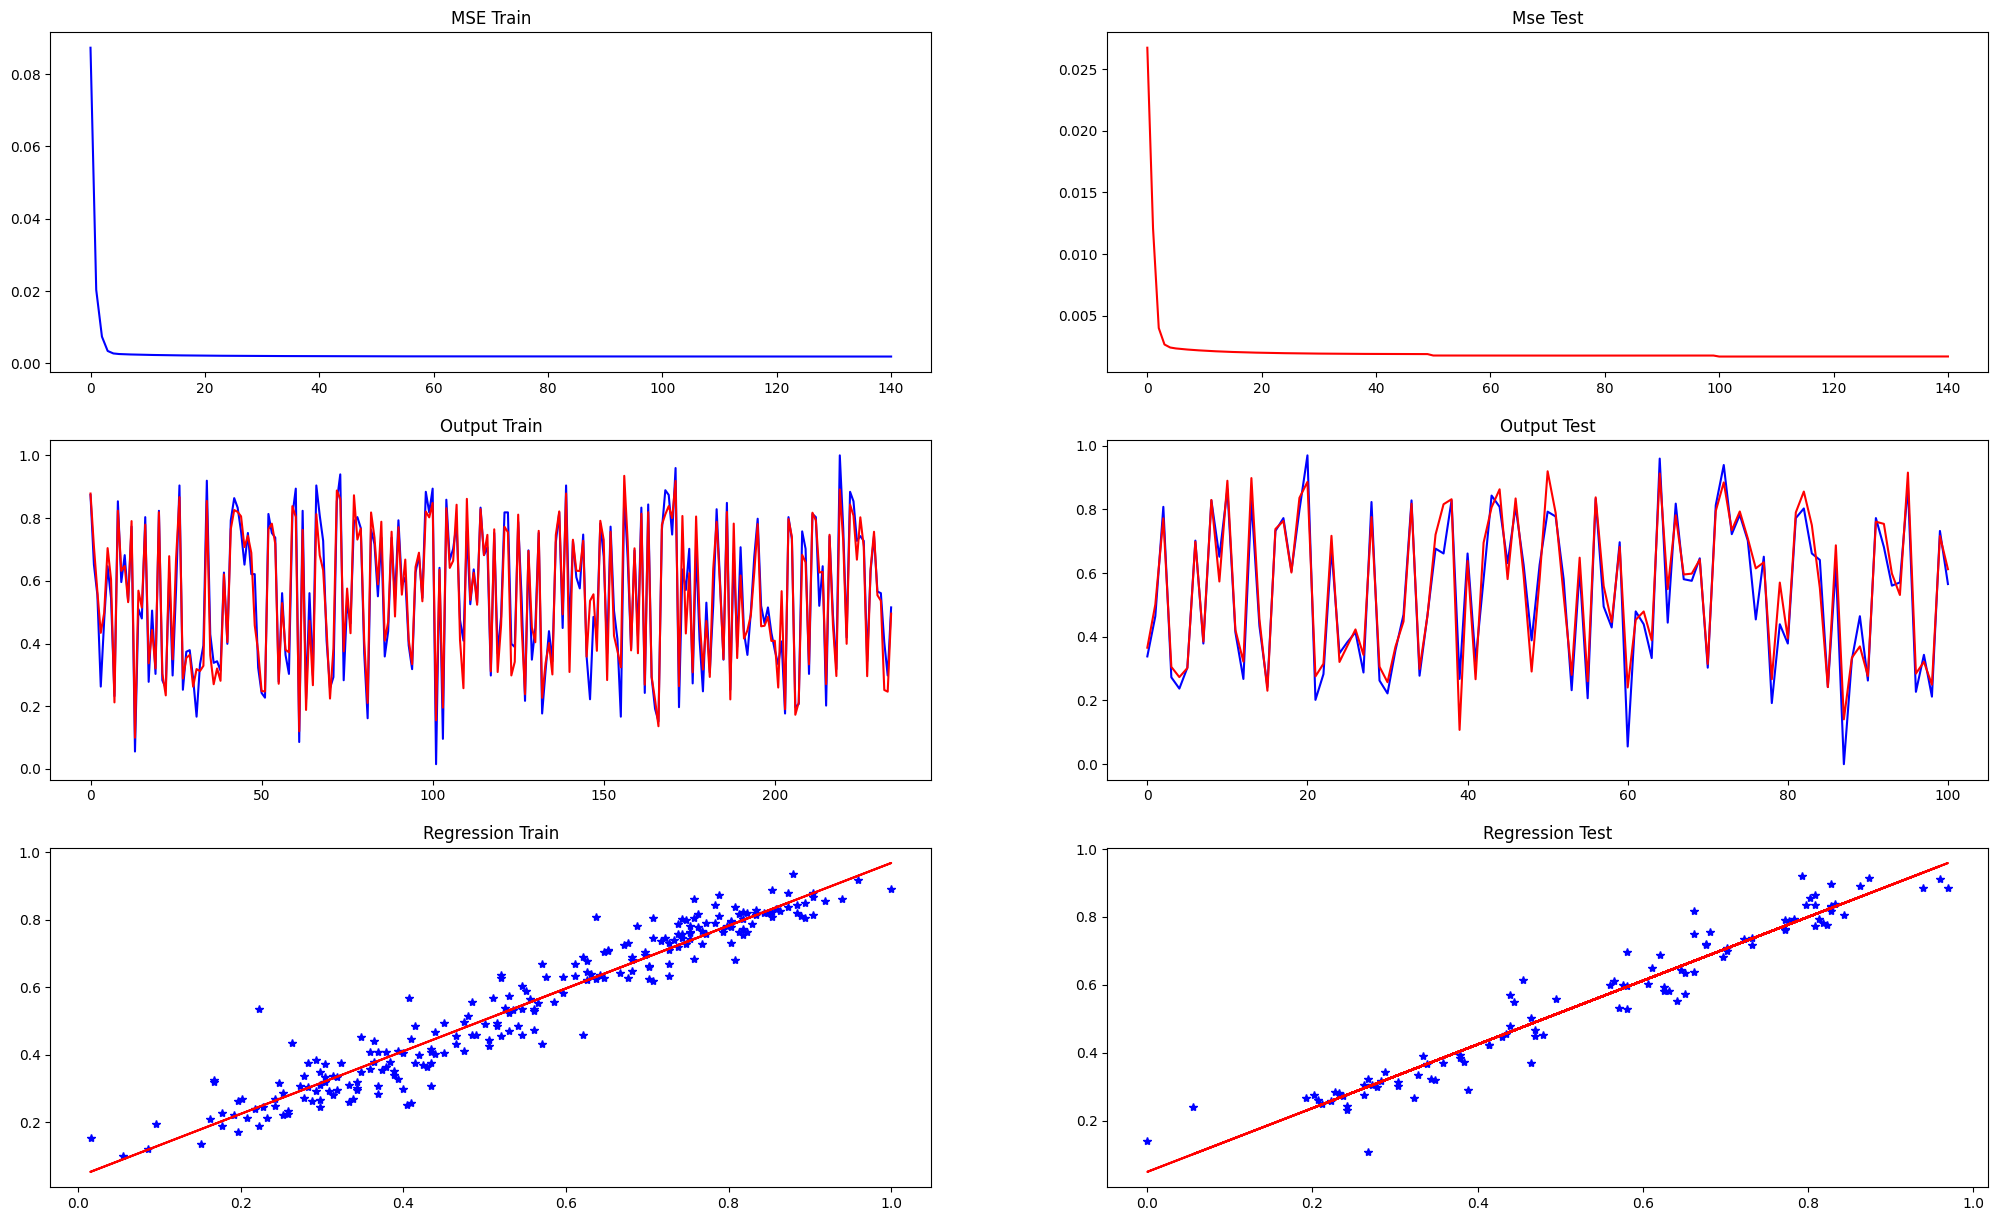

Epoch: 141 	, time: 2.667
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92753853] [0.0398205] [0.93798977] [0.0492483]
Epoch: 142 	, time: 0.020
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92754302] [0.03981919] [0.9379988] [0.04924864]
Epoch: 143 	, time: 0.040
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92754745] [0.03981791] [0.93800773] [0.04924894]
Epoch: 144 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92755184] [0.03981663] [0.93801659] [0.04924922]
Epoch: 145 	, time: 0.022
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92755618] [0.03981536] [0.93802536] [0.04924946]
Epoch: 146 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92756047] [0.03981411] [0.93803404] [0.04924967]
Epoch: 147 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92756471] [0.03981287] [0.93804264] [0.04924986]
Epoch: 148 	, time: 0.023
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.9275689] [0.03981164] [0.93805117] [0.04925001]
Epoch: 149 	, time: 0.027
MSE_train: 0.0019 	, MSE_test: 0.0017
[0.92757304]

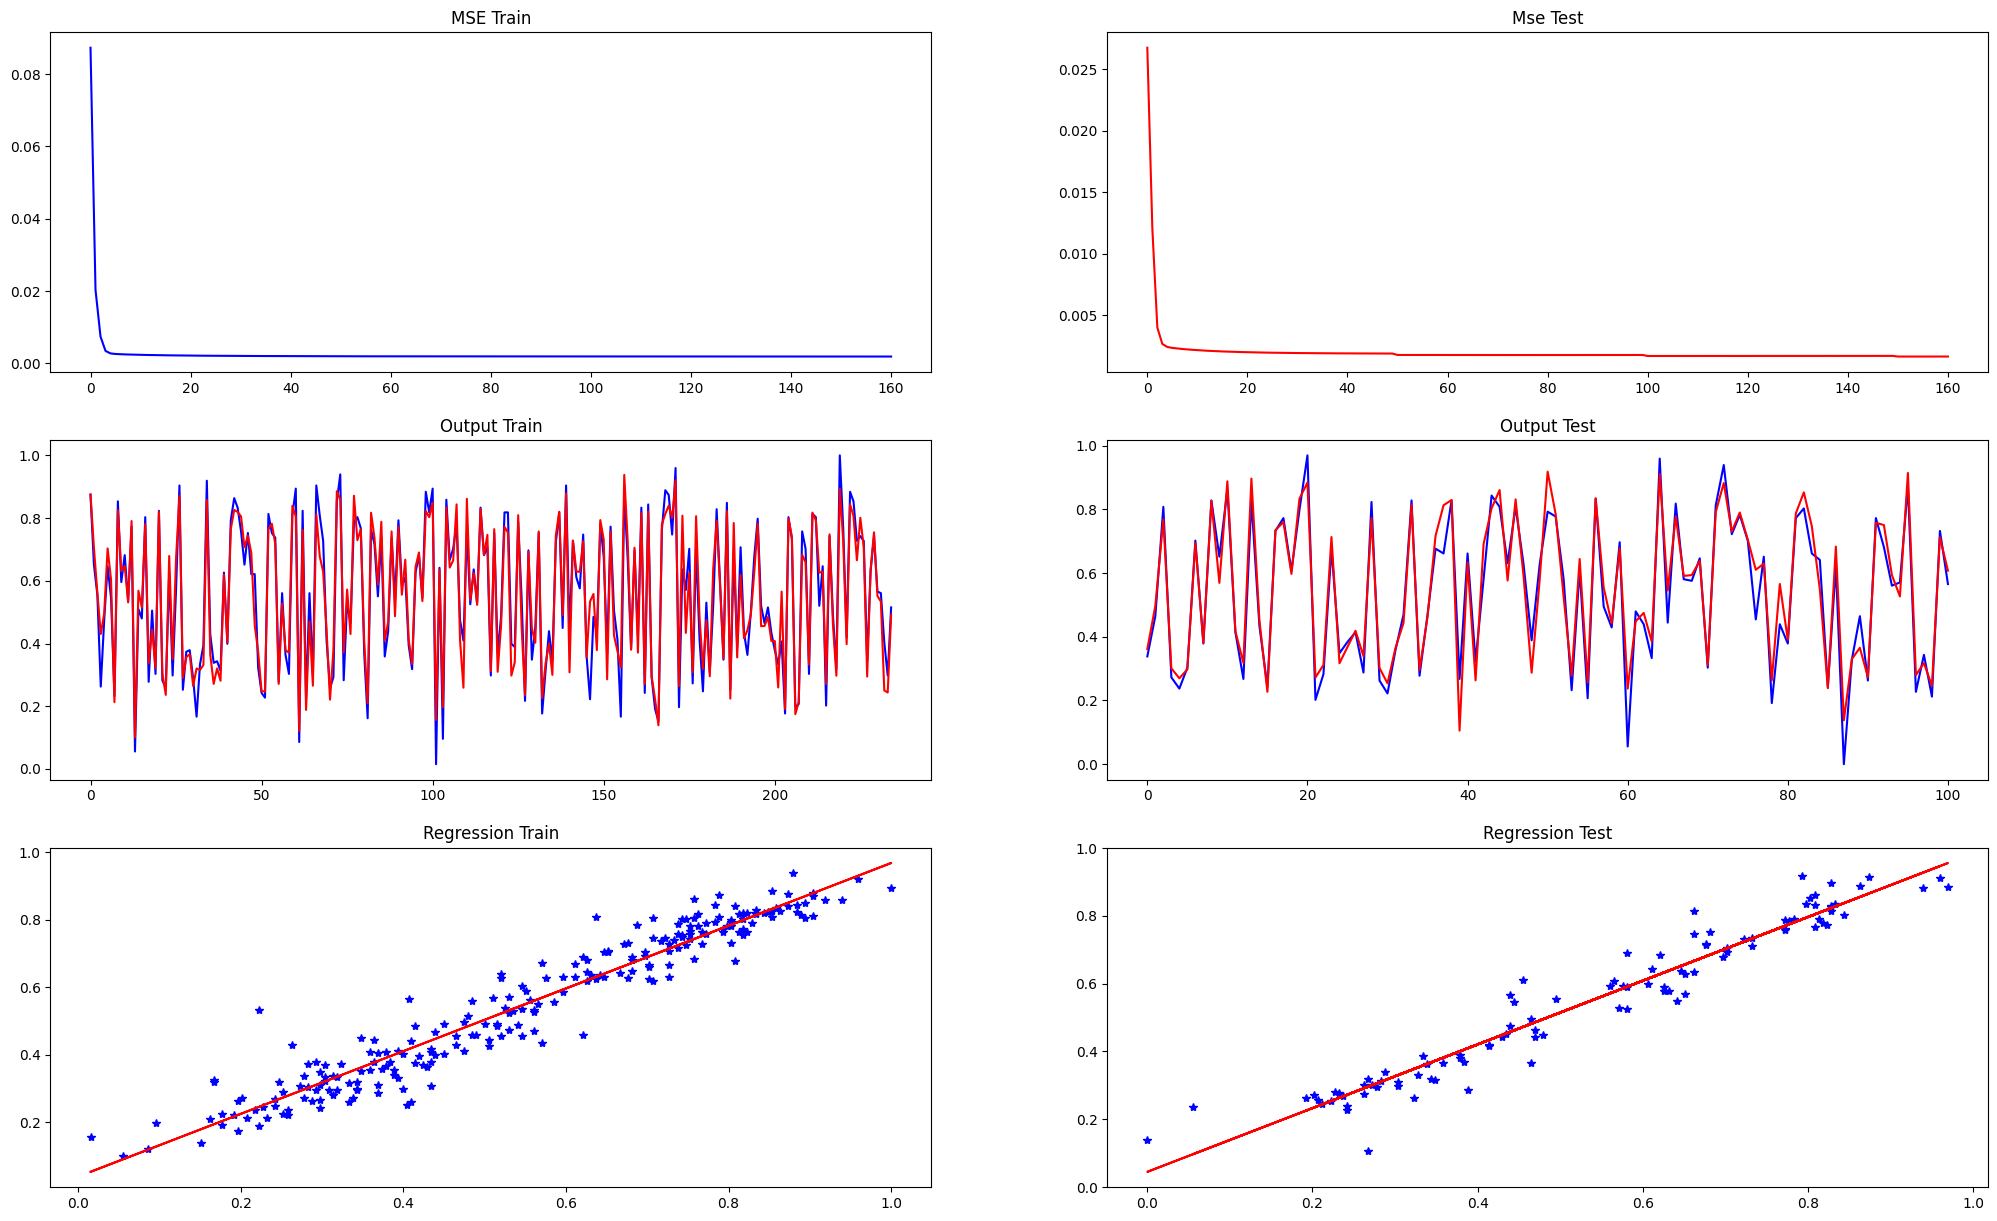

Epoch: 161 	, time: 2.110
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.9276218] [0.03978911] [0.93948571] [0.04473684]
Epoch: 162 	, time: 0.023
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.927631] [0.03978483] [0.93949663] [0.04473392]
Epoch: 163 	, time: 0.023
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92763848] [0.03978147] [0.93950609] [0.04473175]
Epoch: 164 	, time: 0.023
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92764471] [0.03977879] [0.93951447] [0.04473012]
Epoch: 165 	, time: 0.022
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92765002] [0.03977659] [0.93952207] [0.04472888]
Epoch: 166 	, time: 0.025
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92765465] [0.03977475] [0.93952908] [0.04472791]
Epoch: 167 	, time: 0.027
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92765878] [0.03977318] [0.93953565] [0.04472715]
Epoch: 168 	, time: 0.024
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92766254] [0.0397718] [0.9395419] [0.04472654]
Epoch: 169 	, time: 0.023
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92766602] 

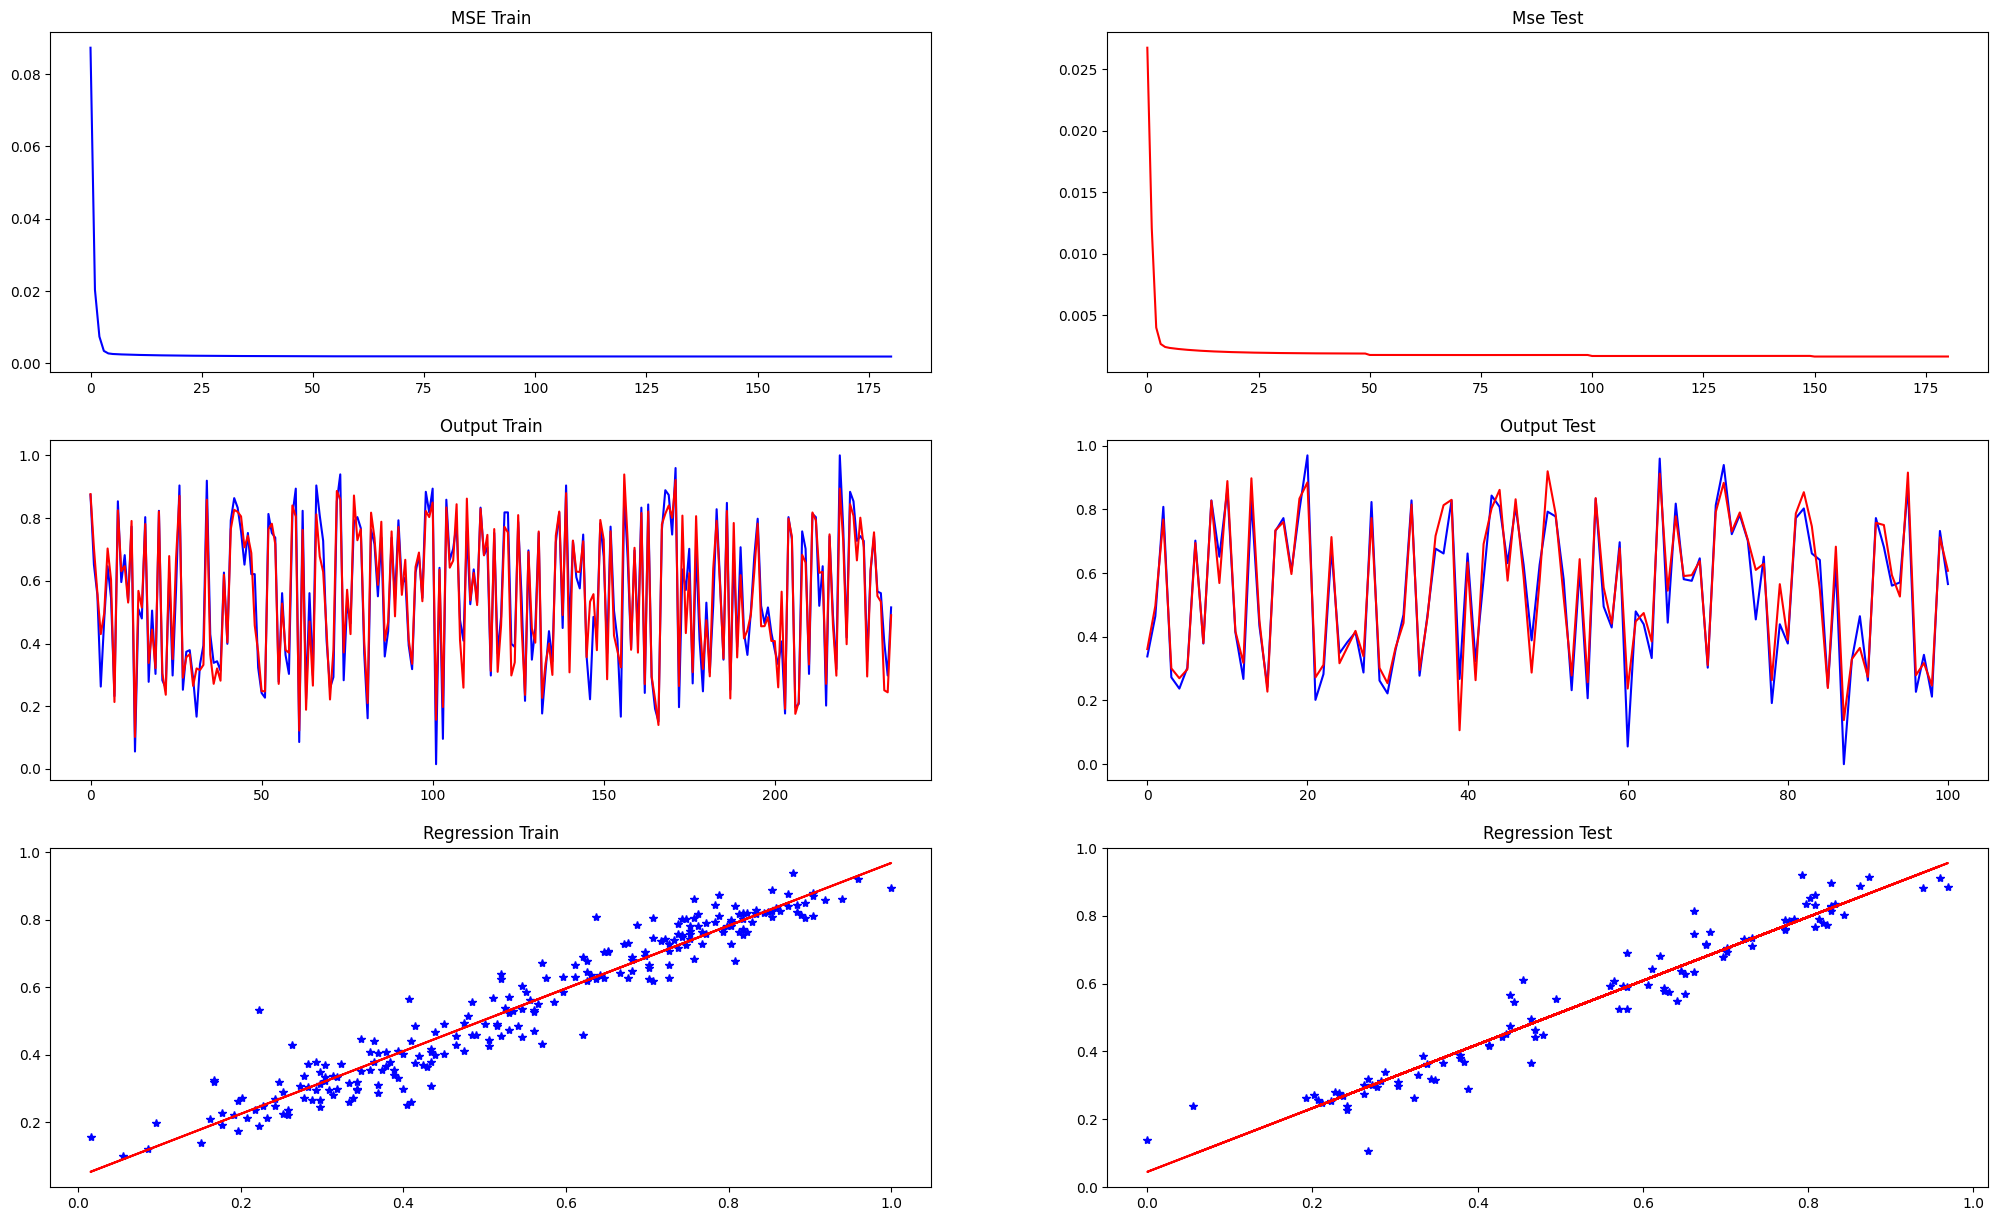

Epoch: 181 	, time: 2.368
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92769971] [0.03975961] [0.93961203] [0.04472176]
Epoch: 182 	, time: 0.024
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92770225] [0.03975881] [0.93961706] [0.04472139]
Epoch: 183 	, time: 0.023
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92770477] [0.03975801] [0.93962206] [0.044721]
Epoch: 184 	, time: 0.025
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92770726] [0.03975721] [0.93962703] [0.04472061]
Epoch: 185 	, time: 0.031
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92770974] [0.03975642] [0.93963197] [0.04472021]
Epoch: 186 	, time: 0.025
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92771219] [0.03975564] [0.93963688] [0.04471979]
Epoch: 187 	, time: 0.023
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92771463] [0.03975486] [0.93964177] [0.04471937]
Epoch: 188 	, time: 0.023
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.92771704] [0.03975409] [0.93964662] [0.04471893]
Epoch: 189 	, time: 0.023
MSE_train: 0.0018 	, MSE_test: 0.0017
[0.9277194

In [84]:
print('==> Start Training ...')
for epoch in range(epochs):
    start = timeit.default_timer()

    if epoch % 50 == 0:
        lrw = 0.75 * lrw
        lrm = 0.75 * lrm
        lrs = 0.75 * lrs

    output_train, w, mean, sigma = Train(w, mean, sigma)
    m_train , b_train = np.polyfit(np.reshape(y_train, (1, -1))[0], output_train, 1)
    output_test = Test(w, mean, sigma)
    m_test , b_test = np.polyfit(np.reshape(y_test, (1, -1))[0], output_test, 1)
    if not epoch % 20:
        Plot_results(output_train,
                    output_test,
                    m_train,
                    b_train,
                    m_test,
                    b_test)

    stop = timeit.default_timer()
    print('Epoch: {} \t, time: {:.3f}'.format(epoch+1, stop-start))
    print('MSE_train: {:.4f} \t, MSE_test: {:.4f}'.format(MSE_train[epoch], MSE_test[epoch]))
    print(m_train, b_train, m_test, b_test)
print('==> End of training ...')


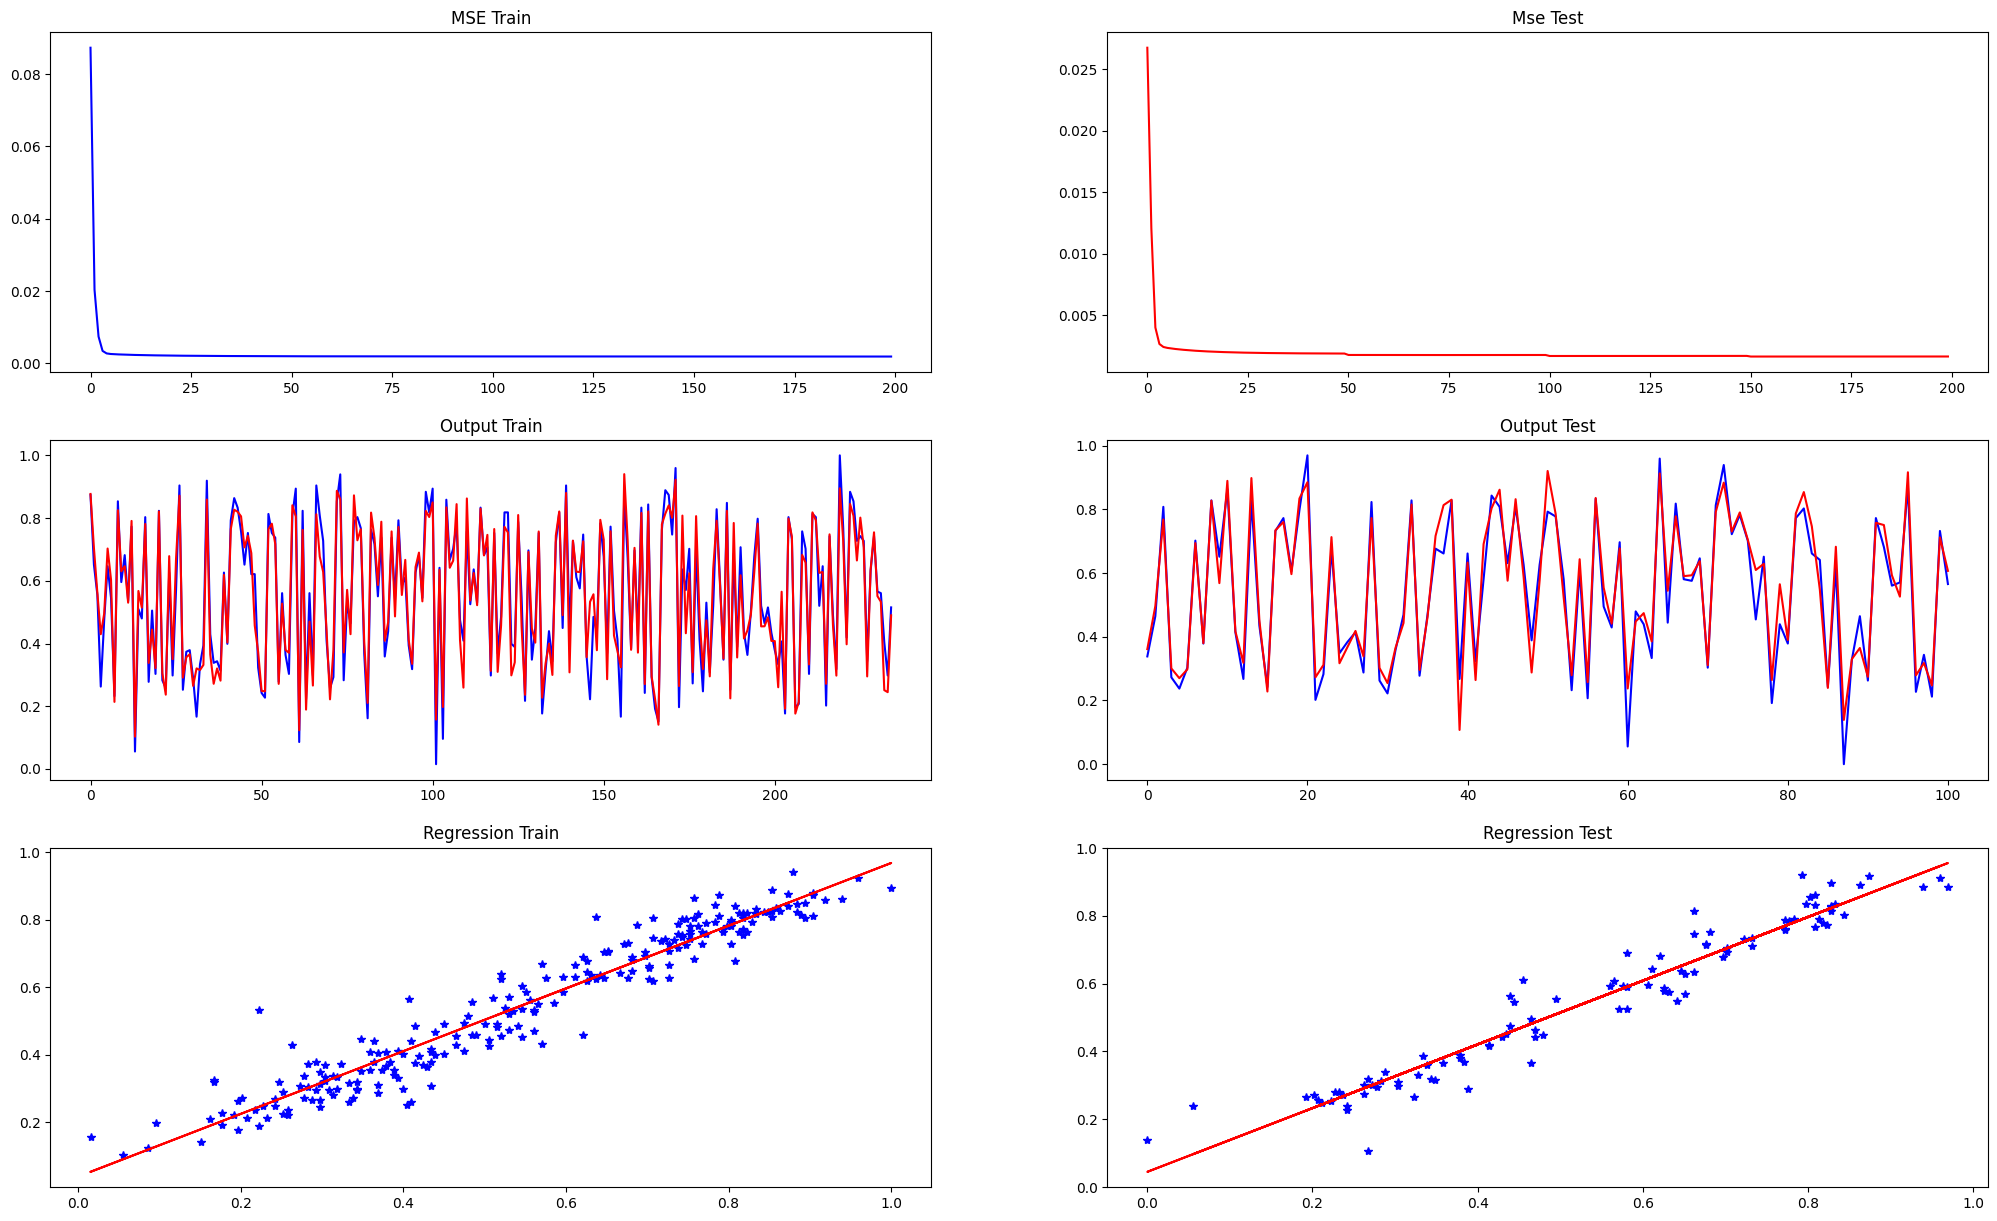

In [85]:
Plot_results(output_train,
                    output_test,
                    m_train,
                    b_train,
                    m_test,
                    b_test)